In [2]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection._split import train_test_split
from skater.core.visualizer.tree_visualizer import plot_tree, tree_to_text
from skater.util.dataops import show_in_notebook

import numpy as np
import pandas as pd

In [3]:
X, y = make_moons(1000, noise=0.5)

X = pd.DataFrame(X, columns=['F1', 'F2'])
print(np.unique(y))
print(X.columns)
print("*List the feature type* \n", X.dtypes)
X.head()

[0 1]
Index(['F1', 'F2'], dtype='object')
*List the feature type* 
 F1    float64
F2    float64
dtype: object


,F1,F2
0,1.528463,0.116095
1,0.423794,0.375162
2,0.773358,-1.173712
3,0.408984,-0.573909
4,-1.033512,0.845130


## Base Model

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier_est = DecisionTreeClassifier(max_depth=10, random_state=5)
classifier_est.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [5]:
X_train.head()

,F1,F2
920,-0.883938,0.496170
985,-0.291558,0.066216
661,0.667181,-0.184908
988,0.511056,-0.739788
380,0.492396,0.015244


In [6]:
y_hat_train = classifier_est.predict(X_train)
y_hat = classifier_est.predict(X_test)

In [7]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.96      0.92      0.94       381
    class 1       0.92      0.96      0.94       369

avg / total       0.94      0.94      0.94       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.76      0.71      0.73       119
    class 1       0.75      0.79      0.77       131

avg / total       0.75      0.75      0.75       250



In [8]:
g_inst = plot_tree(classifier_est, color_list=['maroon', 'darkturquoise'], feature_names=X.columns, class_names=target_names)
g_inst.write_png("original_tree.png")

True

2018-09-13 07:34:12,577 - skater.util.dataops - INFO - File Name: original_tree.png


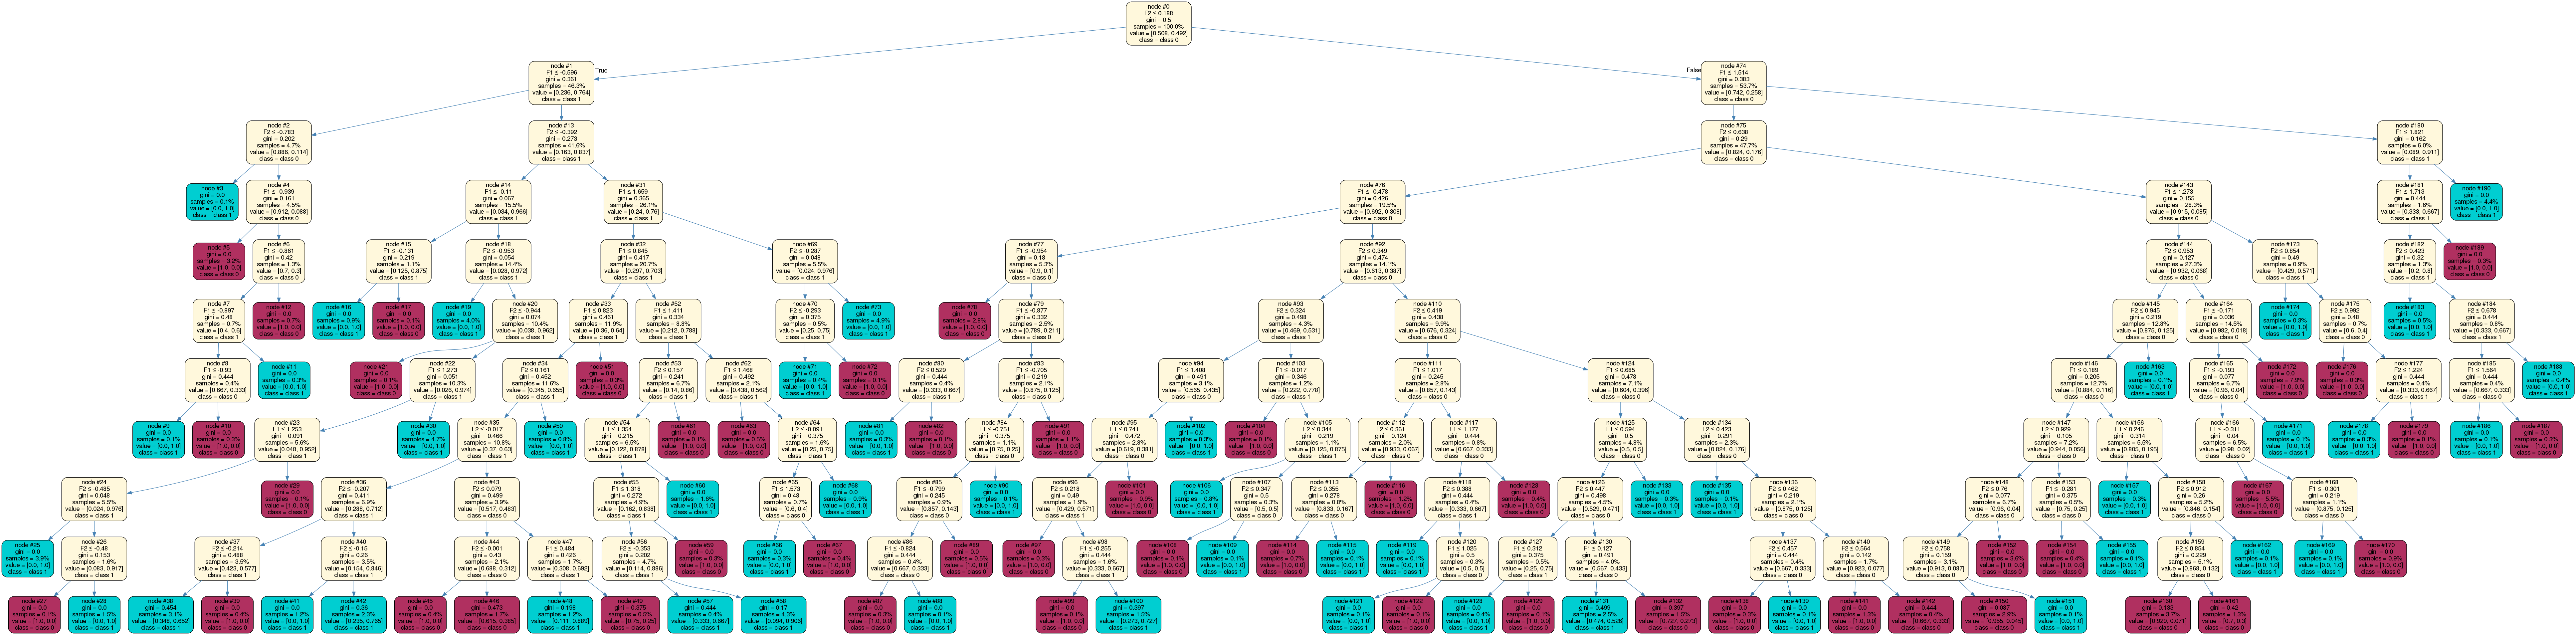

In [9]:
show_in_notebook('original_tree.png', width=1200, height=500)

### Plotting decision boundary

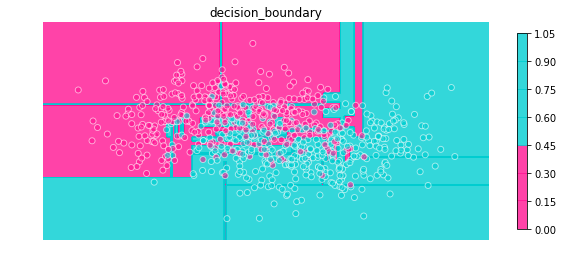

In [10]:
%matplotlib inline
from skater.core.visualizer import decision_boundary as db
_, _ = db.plot_decision_boundary(classifier_est, X0=X_train.iloc[:, 0], X1=X_train.iloc[:, 1], Y=y_train, width=10,
                          height=4, static_color_map=['deeppink', 'darkturquoise'])

# plots could be accessed later as well
# show_in_notebook('./decision_plot.png')

In [11]:
_, _ = db.plot_decision_boundary(classifier_est, X0=X_train.iloc[:, 0], X1=X_train.iloc[:, 1], 
                                 Y=y_train, mode='interactive', height=6, width=10, file_name='iplot')

## Generating explanations using Tree based Surrogates

In [11]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO, _DEBUG

interpreter = Interpretation(X_train, feature_names=X.columns)
model_inst = InMemoryModel(classifier_est.predict, examples=X_train, model_type='classifier', 
                           unique_values=[0, 1], probability=False,
                           feature_names=X.columns, target_names=target_names, log_level=_INFO)

#### 1. Using Pre-pruning

In [12]:
# 1. Learner is trained on the decisions of the base model when use_oracle=True; when 'False' original labels are used
# to learn a more interpretable tree based model.

# 2. Learner uses F1 metric as the default metric of choice for classification.
# 3. set verbose=True for more detailed information
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2018-09-13 07:20:59,043 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-13 07:20:59,043 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-09-13 07:20:59,219 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-13 07:20:59,221 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.891; oracle score 0.964
2018-09-13 07:20:59,222 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.073 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.073

In [13]:
## decision boundary using the tree surrogates
# because "use_oracle=True"
y_hat = model_inst._execute(X_train)
_, _ = db.plot_decision_boundary(surrogate_explainer, X0=X_train.iloc[:, 0], X1=X_train.iloc[:, 1], 
                                 Y=y_hat, mode='interactive', height=6, width=10)

2018-09-13 07:20:59,232 - skater.core.global_interpretation.tree_surrogate - INFO - No pruning applied ...
2018-09-13 07:20:59,234 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-13 07:20:59,236 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.891; oracle score 1.0
2018-09-13 07:20:59,237 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.109 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


In [14]:
y_hat_train_s_pre = surrogate_explainer.predict(X_train)
y_hat_s_pre = surrogate_explainer.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_pre, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_pre, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.87      0.84      0.86       375
    class 1       0.85      0.87      0.86       375

avg / total       0.86      0.86      0.86       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.86      0.71      0.78       125
    class 1       0.75      0.88      0.81       125

avg / total       0.80      0.80      0.79       250



2018-09-13 07:20:59,924 - skater.util.dataops - INFO - File Name: test_tree_pre.png


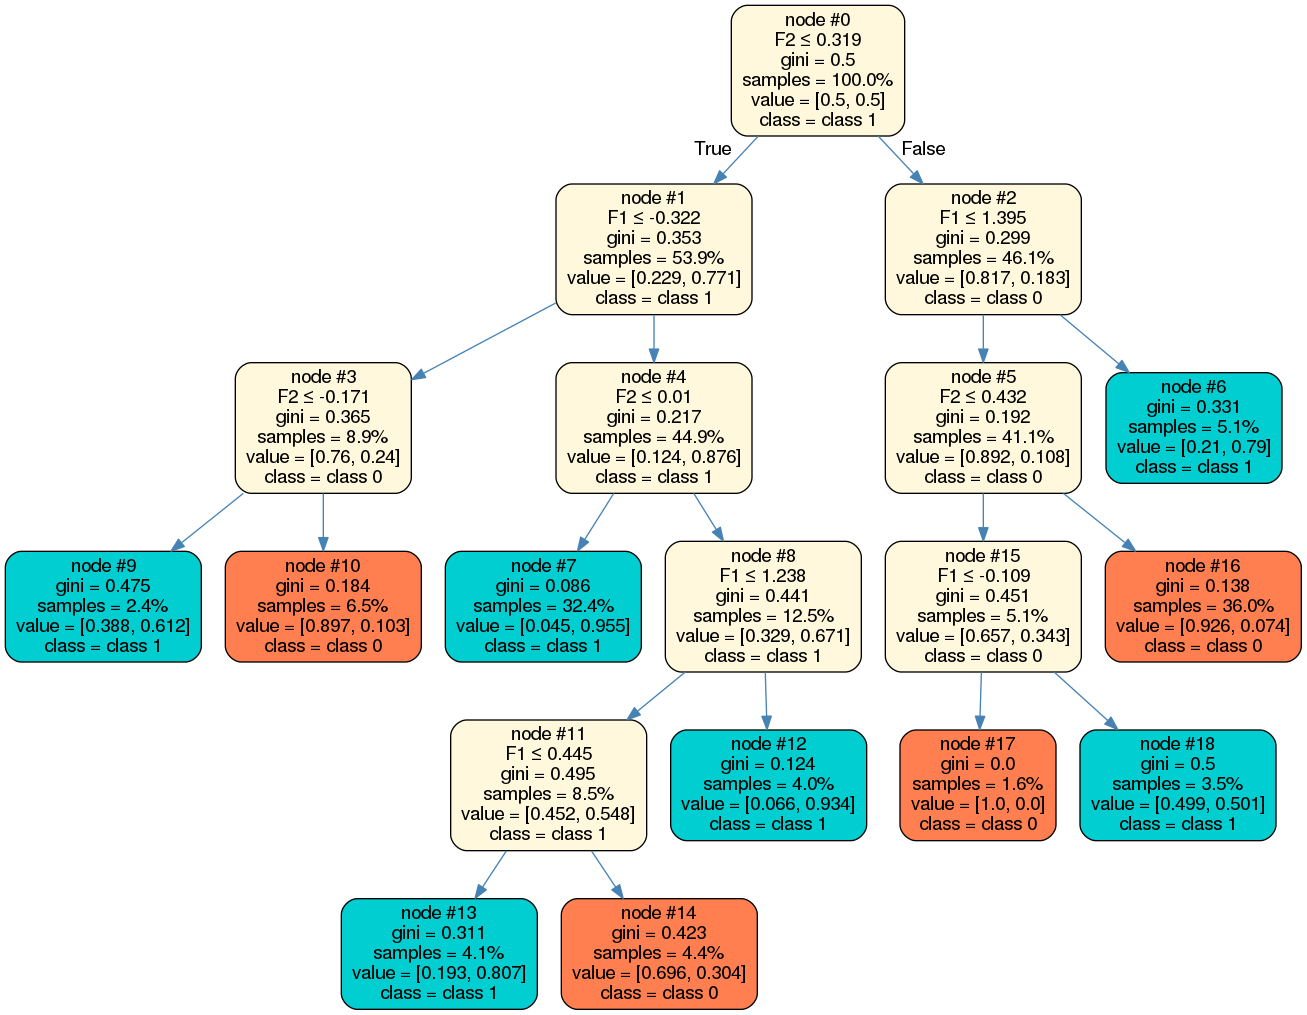

In [15]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png')
show_in_notebook('test_tree_pre.png', width=600, height=500)

#### 2. Post pruning

In [19]:
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer2.fit(X_train, y_train, use_oracle=True, prune='post', verbose=True, impurity_threshold=0.5)

2018-09-13 00:04:01,825 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-13 00:04:01,828 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in ground truth provided [0 1]
2018-09-13 00:04:01,829 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in predictions generated [0 1]
2018-09-13 00:04:01,830 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-09-13 00:04:01,831 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-13 00:04:01,834 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.37562069962416883
2018-09-13 00:04:01,835 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 0 back
2018-09-13 00:04:01,836 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9159341382627108
2018-09-13 00:04:01,837 - skater.core.global_interpreta

2018-09-13 00:04:01,893 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9159341382627108
2018-09-13 00:04:01,894 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:56-->[left node: 57, right node: 58])
2018-09-13 00:04:01,895 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9159341382627108
2018-09-13 00:04:01,896 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:58-->[left node: 59, right node: 64])
2018-09-13 00:04:01,897 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9159341382627108
2018-09-13 00:04:01,898 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:59-->[left node: 60, right node: 63])
2018-09-13 00:04:01,899 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9159341382627108
2018-09-13 00:04:01,900 - skater.core.global_interpretation.tree_surrogat

2018-09-13 00:04:01,956 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.8414304994890784
2018-09-13 00:04:01,957 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:117-->[left node: 118, right node: 123])
2018-09-13 00:04:01,958 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.8414304994890784
2018-09-13 00:04:01,959 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:118-->[left node: 119, right node: 120])
2018-09-13 00:04:01,960 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.8414304994890784
2018-09-13 00:04:01,961 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:120-->[left node: 121, right node: 122])
2018-09-13 00:04:01,962 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.8414304994890784
2018-09-13 00:04:01,963 - skater.core.global_interpretation.tree

0.076

2018-09-13 00:04:02,203 - skater.util.dataops - INFO - File Name: test_tree_post.png


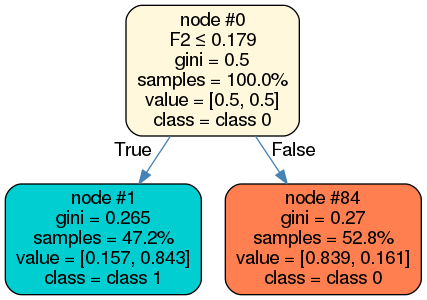

In [20]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_post.png')
show_in_notebook('test_tree_post.png', width=300, height=300)

In [21]:
y_hat_train_s_post = surrogate_explainer2.predict(X_train)
y_hat_s_post = surrogate_explainer2.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_post, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_post, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.74      0.79      0.77       375
    class 1       0.77      0.73      0.75       375

avg / total       0.76      0.76      0.76       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.79      0.75      0.77       125
    class 1       0.76      0.80      0.78       125

avg / total       0.78      0.78      0.78       250



#### Optimizing on cross-entropy instead of F1-Score

In [22]:
interpreter = Interpretation(X_train, feature_names=X.columns)
# passing probability scoring function and setting probability to true makes the scorer chose cross-entropy(log-loss)
# as the cost function.
model_inst = InMemoryModel(classifier_est.predict_proba, examples=X_train, model_type='classifier', probability=True,
                           unique_values=[0, 1], feature_names=X.columns, target_names=target_names, 
                           log_level=_INFO)

# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)

# either use keywords'default' or 'cross_entropy' for scorer_type
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='default')

2018-09-13 00:04:03,741 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-13 00:04:03,742 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2018-09-13 00:04:03,923 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750, 2)
2018-09-13 00:04:03,926 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.438; oracle score 0.194


-0.244

### 3. Building interpretable models

In [23]:
# One could also use TreeSurrogates to build Interpretable models not just surrogates
surrogate_explainer3 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer3.fit(X_train, y_train, use_oracle=False, prune='pre', scorer_type='default', verbose=True)

2018-09-13 00:04:04,332 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-13 00:04:04,333 - skater.core.global_interpretation.tree_surrogate - DEBUG - Default search space used for CV : {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12], 'min_samples_leaf': [2, 4], 'max_leaf_nodes': [2, 4, 6, 8, 10]}
2018-09-13 00:04:04,335 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy, score=9.901217182215554, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy, score=7.598616097272903, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy, score=6.677566068126683, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy, score=9.440700163616745, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=4, max_leaf_nodes=2, max_depth=4, criterion=entropy, score=8.749908643769928, tot

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
2018-09-13 00:04:04,543 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750, 2)
2018-09-13 00:04:04,545 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.552; oracle score 0.194


[CV]  min_samples_leaf=2, max_leaf_nodes=6, max_depth=4, criterion=entropy, score=6.217038388228804, total=   0.0s


-0.358

In [24]:
y_hat_train_s_i = surrogate_explainer3.predict(X_train)
y_hat_s_i = surrogate_explainer3.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_i, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_i, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.74      0.79      0.77       375
    class 1       0.77      0.73      0.75       375

avg / total       0.76      0.76      0.76       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.79      0.75      0.77       125
    class 1       0.76      0.80      0.78       125

avg / total       0.78      0.78      0.78       250



2018-09-13 00:04:04,881 - skater.util.dataops - INFO - File Name: test_tree_interpretable.png


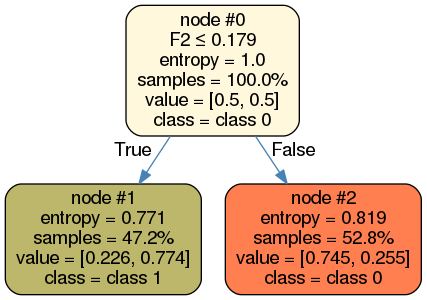

In [25]:
surrogate_explainer3.plot_global_decisions(colors=['coral', 'darkkhaki'], 
                                          file_name='test_tree_interpretable.png')
show_in_notebook('test_tree_interpretable.png', width=300, height=300)